# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


This notebook was made with celloracle version 0.6.9.
Please use celloracle>=0.6.9. Otherwise you may get an error.

In [3]:
import celloracle as co
co.__version__

'0.10.10'

In [4]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [9,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [5]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for the notes on how to prepare the oracle object.

In [6]:
oracle = co.data.load_tutorial_oracle_object()

## 1.2. Load inferred GRNs

In the previous notebook, we calculated GRNs. Now, we will use these GRNs for simulation.
We import GRNs which were saved in the Links object.


In [7]:
links = co.data.load_tutorial_links_object()

# 2. Make predictive models for simulation

We will fit ridge regression models again.
This process takes less time than the GRN inference in the previous notebook because we only use significant TFs to predict target gene instead of all regulatory candidate TFs. 

In [8]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

# 3. in silico Perturbation-simulation

Next, we will simulate  the effects of perturbing a single TF to investigate its function and regulatory mechanism.
See the celloracle paper for the details and scientific premise on the algorithm.


In this notebook, we'll show an example of the simulation; we'll simulate knock-out of  Gata1 gene in the hematopoiesis. 

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation. 

Here, we will analyze Gata1 for the demonstration of celloracle; Celloracle try to recapitulate the previous findings of Gata1 gene above.

## 3.1. Check gene expression pattern.

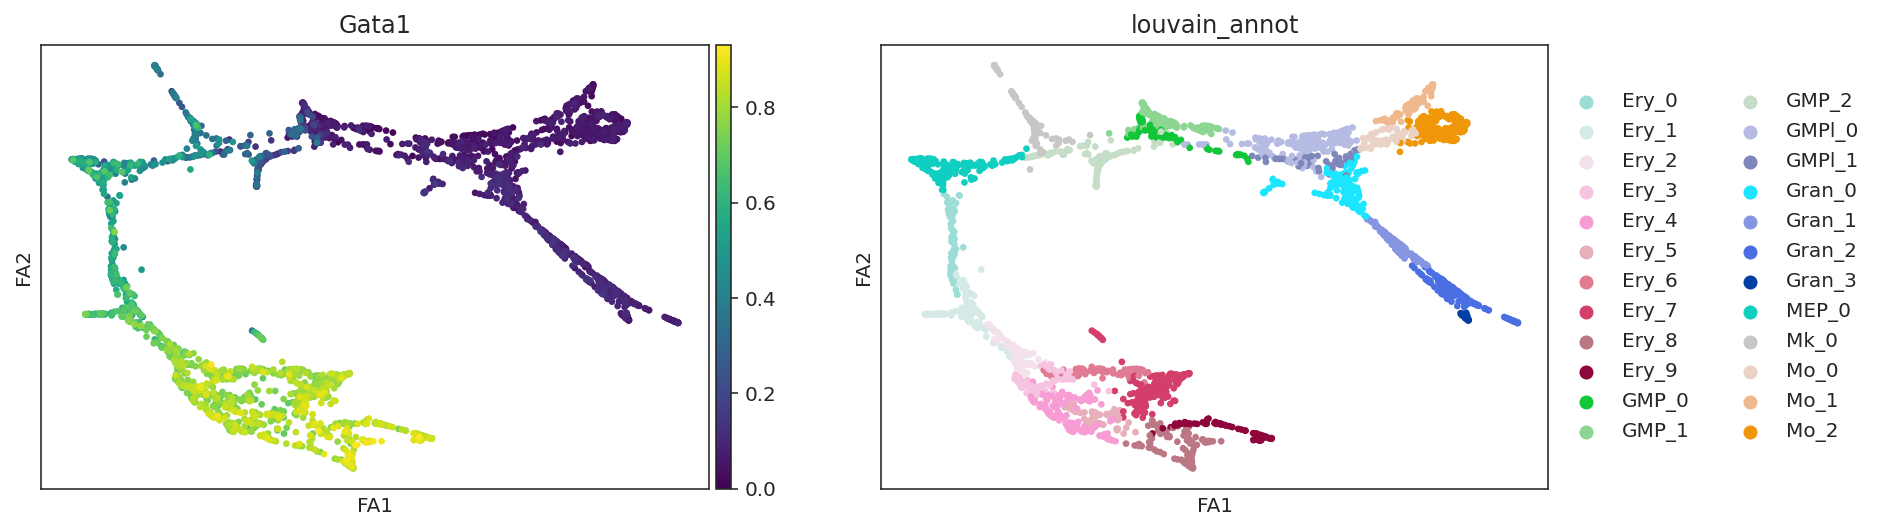

In [10]:
# Check gene expression 
goi = "Gata1"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

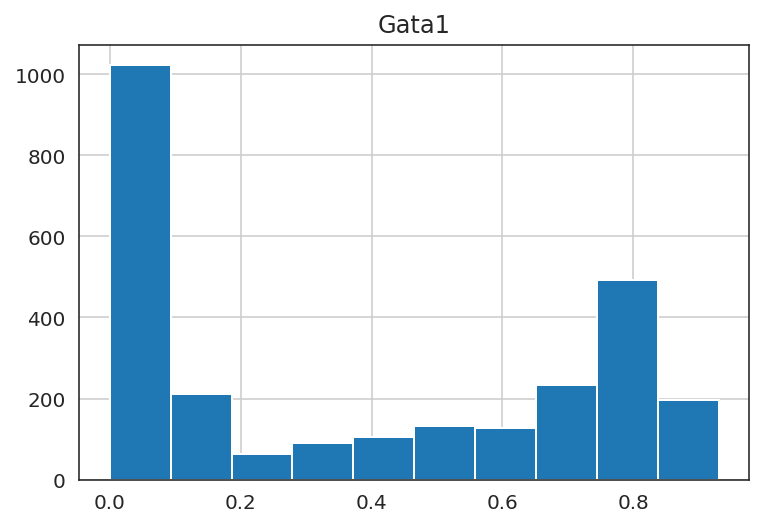

In [11]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

## 3.2. calculate future gene expression after perturbation.

Although you can use any gene expression value for the input of in silico perturbation, we recommend avoiding extreme values which are far from natural gene expression ranges. If you set Gata1 gene expression to 100, for example, it may lead to biologically infeasible results.

Here we simulate Gata1 KO; we predict what happens to the cells if Gata1 gene expression changed into 0.

In [12]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

## 3.3. calculate transition probability between cells

In the step above, we simulated simulated future gene expression values after perturbation. This prediction is based on itelative calculations of signal propagations within the GRN.

Next step, we will calculate the probabilityof a cell state transition based on the simulated data. Using the transition probability between cells, we can predict how a cell changes after perturbation.

This transition probability will be used in two ways.

(1) Visualization of directed trjectory graph.

(2) Markof simulation.

In Step 4.2 and 4.3, we usefunctions imported from the velocytoloom class in velocyto.py. Please see the documentation of VelocytoLoom for more information. http://velocyto.org/velocyto.py/fullapi/api_analysis.html

In [13]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

# 4. Visualization
## 4.1. Quiver plot: Show the direction of cell transition at single cell resolution

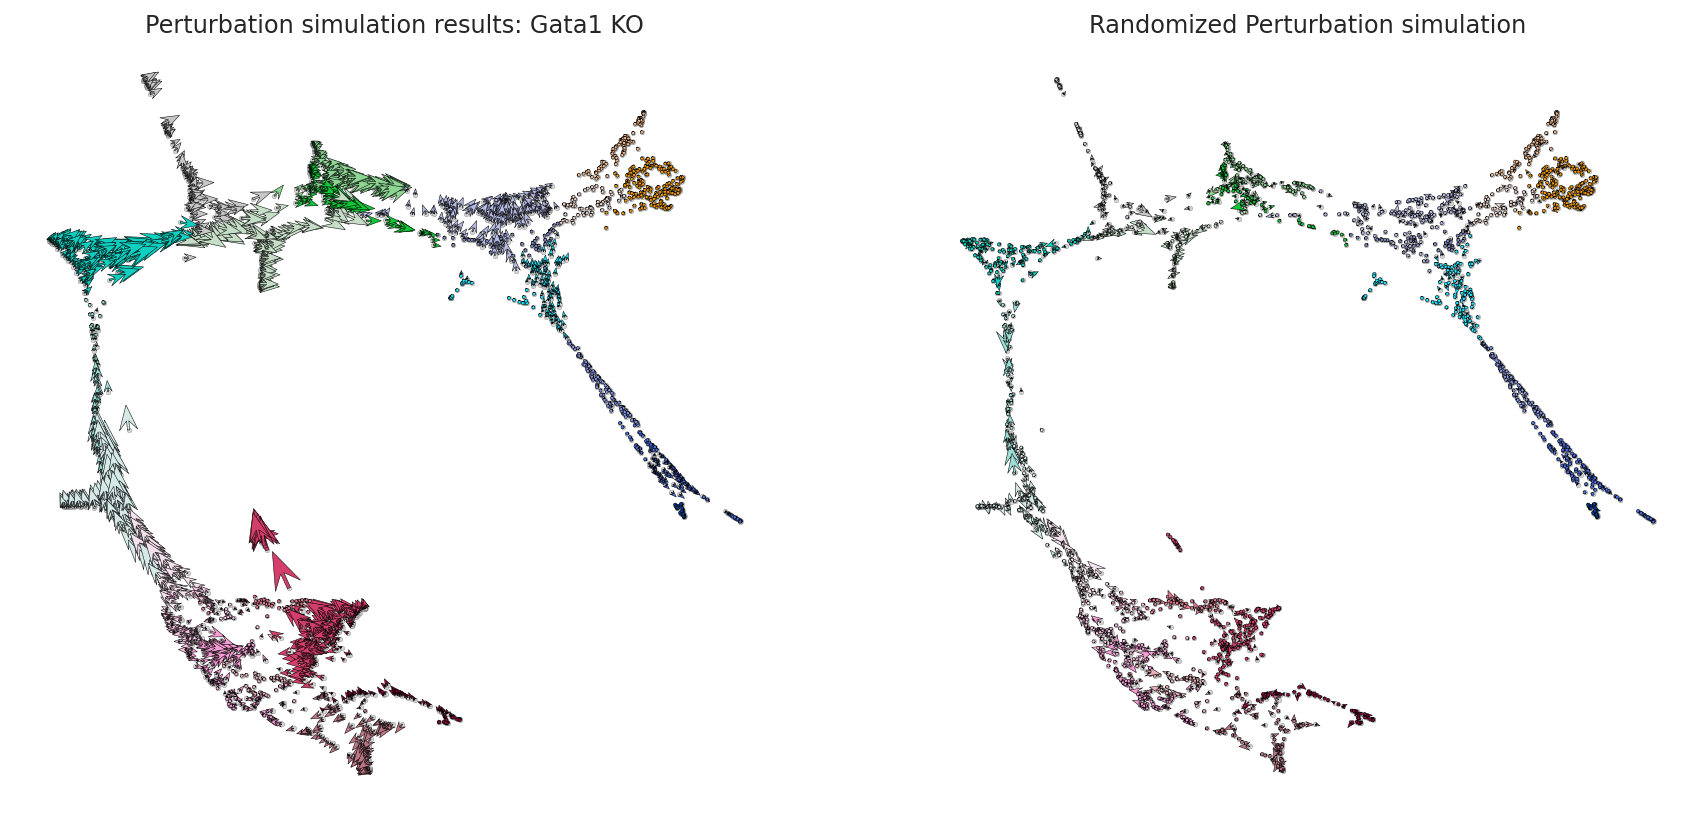

In [14]:
fig, ax = plt.subplots(1, 2,  figsize=[15, 7])

scale = 30
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO")

# Show quiver plot that was calculated with randomized transition probability.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized Perturbation simulation")

plt.show()

## 4.2. Vector field graph

We can visualize simulation result as a vector field graph. Single cell transition vectors are grouped by grid point.


- The grid point that have few cells are removed.
Please adjust `min_mass`  if you get too many or too less grid point.


In [15]:
# Use the same papramters as before.
oracle.calculate_p_mass(smooth=0.8, n_grid=40, n_neighbors=200)
oracle.calculate_mass_filter(min_mass=0.01)

please adjust `scale` parameter.
Plesase try to find optimal `scale` parameter that give you good visualization.
If you see don't see any vector, you can try smaller `scale` parameter.
But if you see some vectors in the right panel, which is the randomized simulation, it means the scale parameter is too small. 

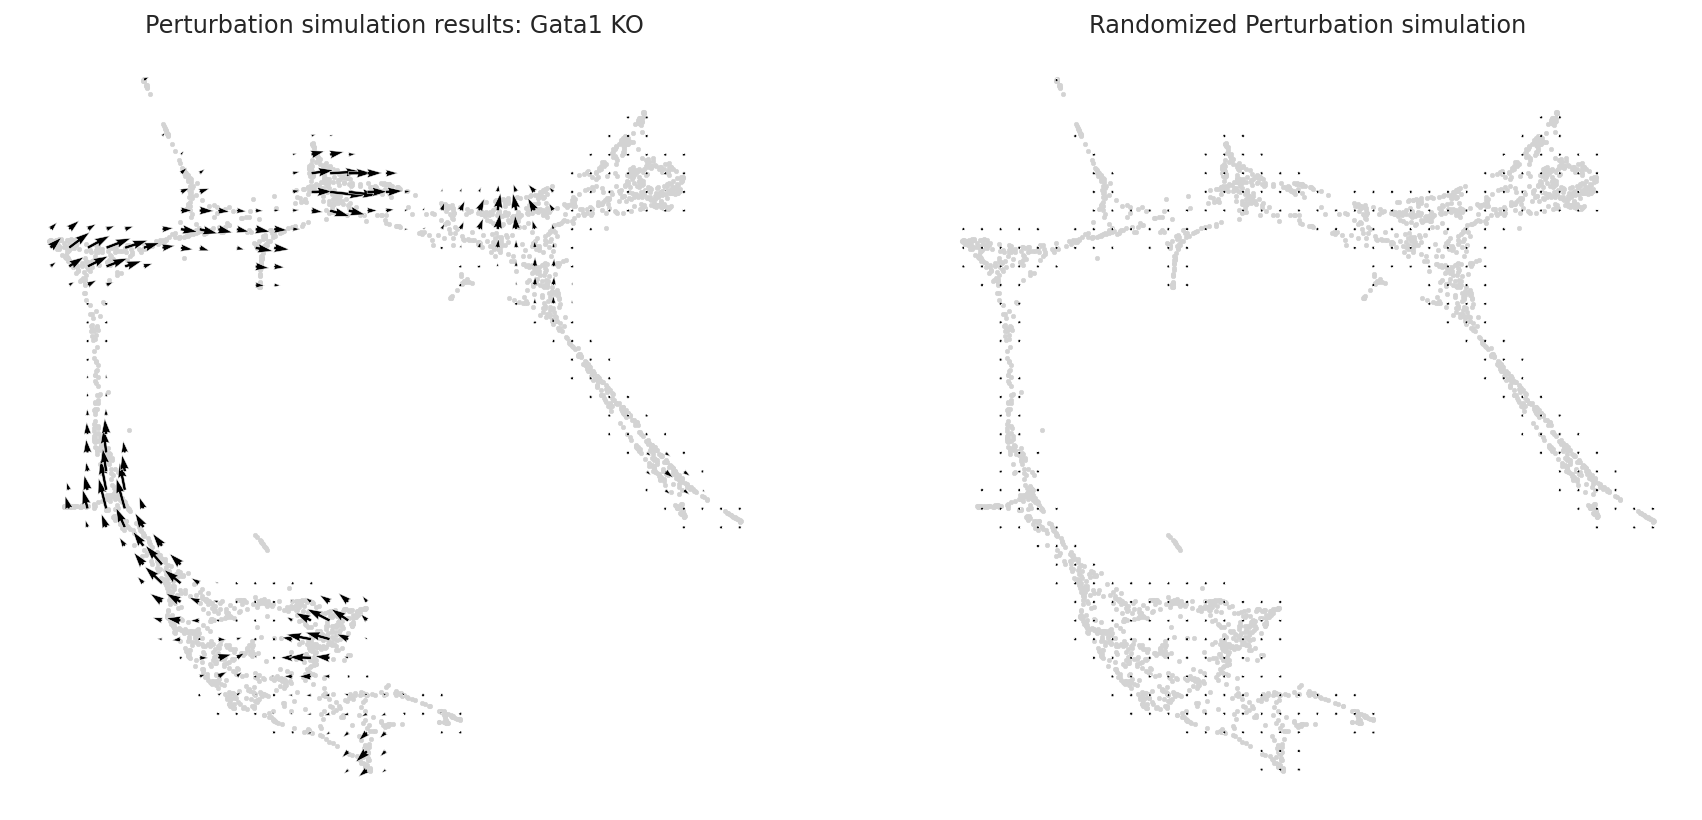

In [16]:
fig, ax = plt.subplots(1, 2,  figsize=[15, 7])

scale_grid = 0.8
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_grid, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO")

# Show quiver plot that was calculated with randomized GRN.
oracle.plot_simulation_flow_random_on_grid(scale=scale_grid, ax=ax[1])
ax[1].set_title(f"Randomized Perturbation simulation")

plt.show()

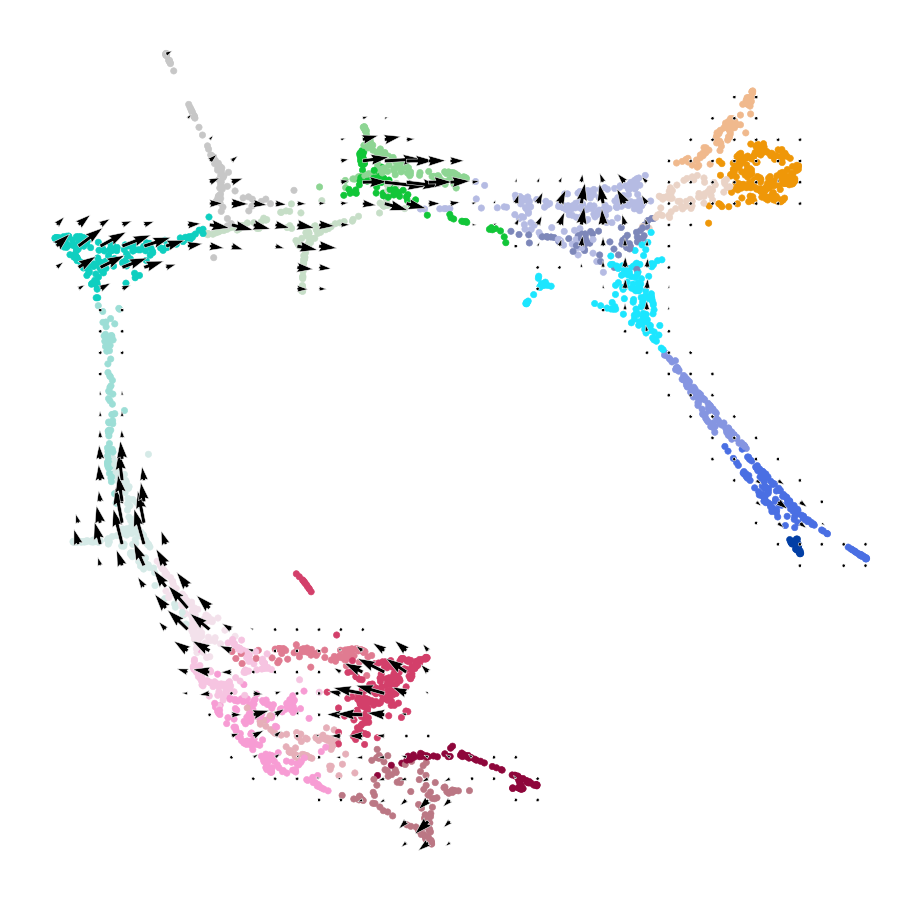

In [17]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_grid, ax=ax, show_background=False)

# 5. Markov simulation to analyze the effects of perturbation on cell fate transition 

We can also simulate cell state transition using Markof simulation.

# 5.1. Do Markov simulation

We will simulate using the parameters, "n_steps=200" and "n_duplication=5" in the following example.

To elaborate, this means:

(1) We will do 200 times of iterative simulations to predict how the cell changes over time

(2) We will repeat 5 rounds of simulations 

In [18]:
%%time
# n_steps is the number of steps in markov simulation. 
# n_duplication is the number of technical duplication for the simulation
oracle.run_markov_chain_simulation(n_steps=200, n_duplication=5)

CPU times: user 15.7 s, sys: 4.1 ms, total: 15.7 s
Wall time: 15.7 s


## 5.2. Check the results of the simulation for specific cells

Check the results of simulation. Pick up some cells and visualize their transition trajectory.



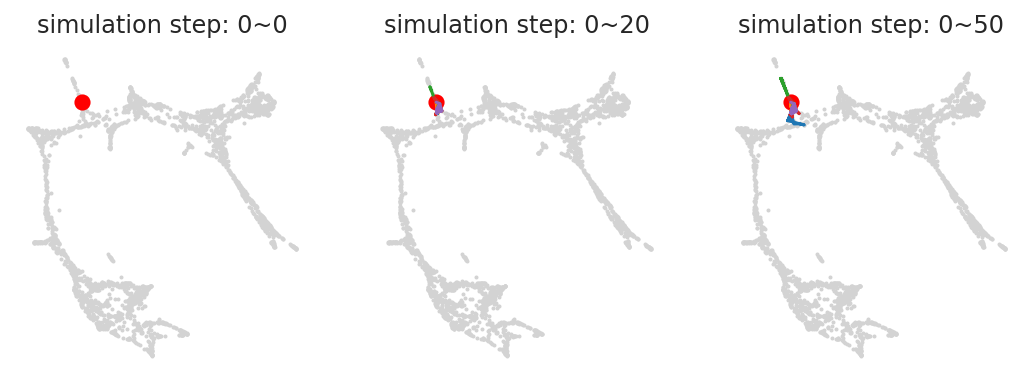

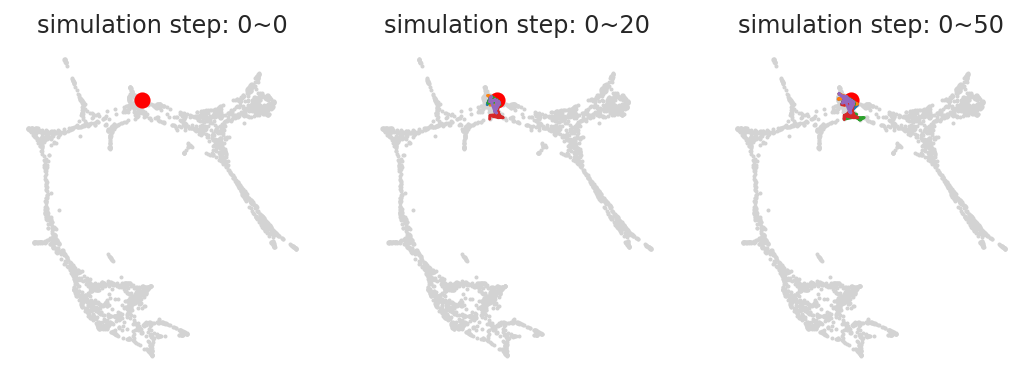

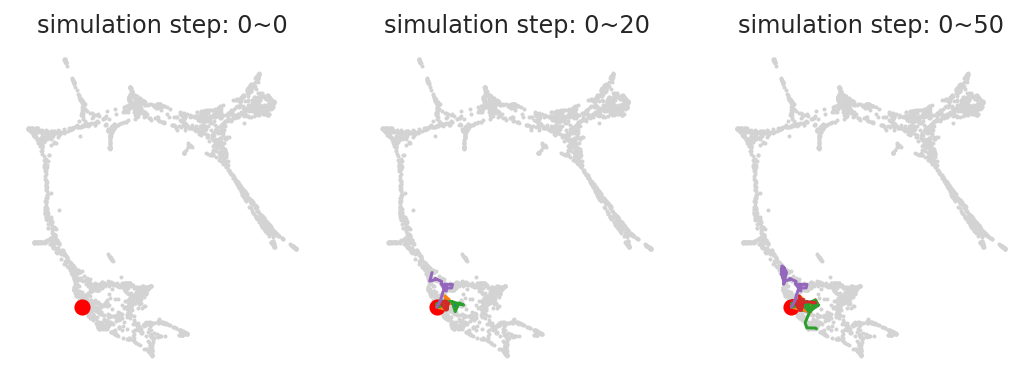

In [20]:
# Randomly pick up 3 cells
np.random.seed(12)
cells = oracle.adata.obs.index.values[np.random.choice(oracle.ixs_mcmc, 3)]

# Visualize the simulated results of cell transition after perturbation
for k in cells:
    print(f"cell {k}")
    plt.figure(figsize=[9, 3])
    for j, i in enumerate([0, 20, 50]): # time points
        plt.subplot(1, 3, (j+1))
        oracle.plot_mc_results_as_trajectory(k, range(0, i))
        plt.title(f"simulation step: 0~{i}")
        plt.axis("off")
    plt.show()

## 5.3. Summarize the results of simulation by plotting sankey diagram

Sankey diagrams are useful when you want to visualize proportional cell transitions between some groups.

For the grouping of cells, you can use arbitrary cluster unit.

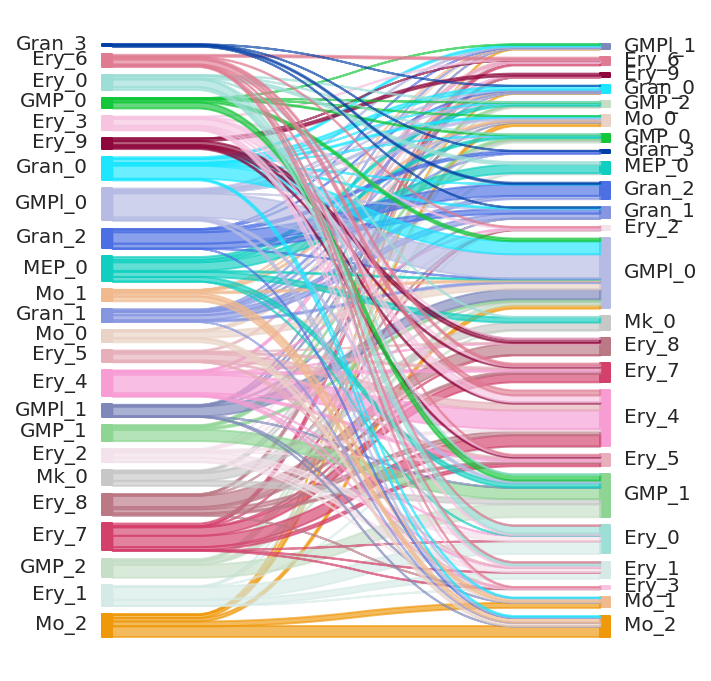

In [21]:
# Plot sankey diagram 
plt.figure(figsize=[5,6])
cl = "louvain_annot"
oracle.plot_mc_results_as_sankey(cluster_use=cl, start=0, end=100)

The Sankey diagram above looks messy because the cluster order is random.

Let's change the cluster order and make the plot again

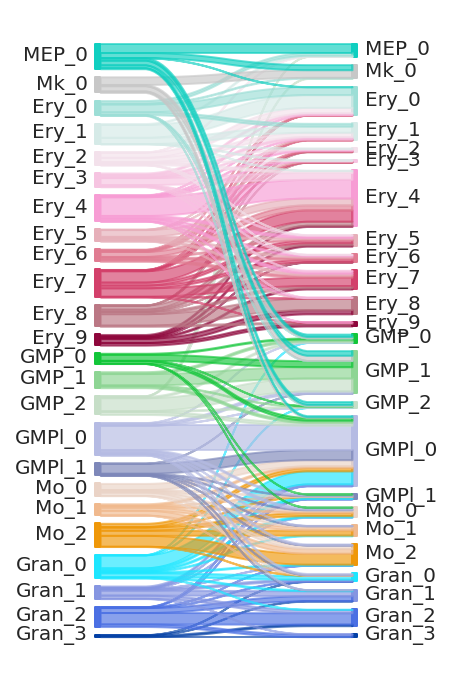

In [22]:

cl = "louvain_annot"
order = ['MEP_0', 'Mk_0','Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 
         'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9',
         'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 
         'Mo_0', 'Mo_1', 'Mo_2', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3']

plt.figure(figsize=[5,6])
plt.subplots_adjust(left=0.3, right=0.7)
oracle.plot_mc_results_as_sankey(cluster_use=cl,  start=0, end=100, order=order)
#plt.savefig(f"{save_folder}/mcmc_{cl}.png")

Make another Saneky diagram with different cluster units.

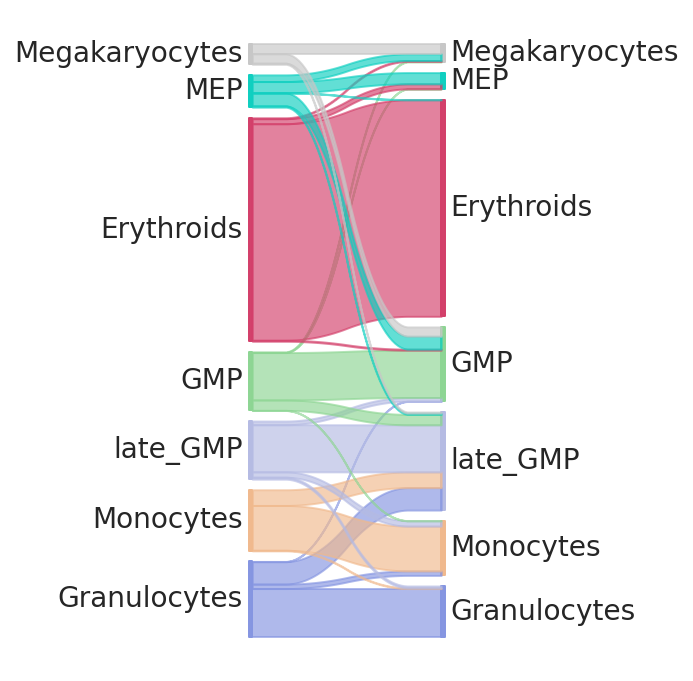

In [23]:
order = ['Megakaryocytes', 'MEP', 'Erythroids', 'GMP', 'late_GMP', 'Monocytes', 'Granulocytes']
cl = "cell_type"

plt.figure(figsize=[5,6])
plt.subplots_adjust(left=0.35, right=0.65)
oracle.plot_mc_results_as_sankey(cluster_use=cl, start=0, end=100, order=order, font_size=14)
#plt.savefig(f"{save_folder}/mcmc_{cl}{goi}.png", transparent=True)

Based on the results, we may conclude several things as follows.

Gata1 KO induced both cell state transitions from Erythroids to MEP, and from MEP to GMP.

(1) These results suggest that Gata1 may play a role in the progression of Erythroid differentiation and cell state determination between the MEP and GMP lineages.

(2) Gata1 KO also induced cell state transitions from granulocytes to late GMP, suggesting Gata1's involvement in Granulocytes differentiation.

These results agree with previous reports about Gata1 and recapitulate Gata1's cell-type-specific function regarding the cell fate decisions in hematopoiesis.